In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy


def read_arduino_2ch_binary(number_readings=1, data_type=numpy.float32, error_value=numpy.NaN, 
                 serial_port='COM3', baud_rate=115200, timeout=2, delay=228,
                 startup_message='Yours sincerely, Arduino'): 
    '''
    Returns number_readings (default 1) voltage measurements as binary data from Arduino 
    attached to serial_port at baud_rate with specified timeout.
    Arduino should give a suitable startup message (string).  
    Returns a numpy array of shape (2, number_readings), of type data_type, and a numpy
    array of timestamps of same shape and type numpy.float32. 
    Returns element with error_value if value cannot be converted to type data_type, but
    attempts to correct timestamp array for errors.
    '''
    if number_readings < 1: number_readings = 1 
    numeric_values = numpy.zeros((2, number_readings), dtype=data_type) 
    time_diffs = numpy.zeros((number_readings,), dtype=data_type) 
    
    import serial
    with serial.Serial(port=serial_port, baudrate=baud_rate, timeout=timeout) as arduino:
        arduino.read_until(startup_message.encode()) 
        for i in range(number_readings):
            binary_data = arduino.read(size=6) 
            try: 
                numeric_values[0, i] = data_type((binary_data[0] + (binary_data[1]*2**8))*5/1023) 
                numeric_values[1, i] = data_type((binary_data[2] + (binary_data[3]*2**8))*5/1023) 
                time_diffs[i] = data_type(binary_data[4] + (binary_data[5]*2**8)) 
            except (ValueError, IndexError):
                numeric_values[0, i] = error_value
                numeric_values[1, i] = error_value
                time_diffs[i] = 0
    
    timestamps = reconstruct_timestamps(time_diffs, 2, delay)
    
    return numeric_values, timestamps*1e-6


def reconstruct_timestamps(diffs, n_channels, delay=228):
    '''
    More robust reconstruction of corrected timestamp array: any zero values
    in 'diffs' due to errors are replaced with the modal value of the rest
    of the array, before making the cumulative sum.
    '''
    from scipy.stats import mode
    try: # Determine the most common (mode) of the valid time_diff values
        mode_diff = mode(diffs[diffs != 0]).mode[0]     
    except IndexError: # If ALL diffs are zero, due to errors, mode.mode = []
        print('Your Arduino sketch is not compatible with this function!')
        mode_diff = 0 #  This will still return array of zeros for timestamps
        
    timestamps = numpy.where(diffs == 0, # replace invalid values
                             mode_diff, # with most common valid value
                             diffs).cumsum() # then take cumulative sum
    return numpy.array([timestamps + i*delay for i in range(n_channels)])


def read_and_discard(number_to_read=1, number_to_discard=100, **kwds):
    '''
    Returns number_to_read (default 1) samples from Arduino by binary transfer, 
    after discarding the first number_to_discard samples (default 100).
    Other arguments passed using **kwds.
    '''
    kwds.pop('number_readings', None) 
    sigs, time = read_arduino_2ch_binary(number_readings=number_to_read+number_to_discard, **kwds)
    return sigs[:, number_to_discard:], time[:, number_to_discard:]

def plot_opamp_signals(signals, times, plot=True):
    '''Display data, on different scales, if plot=True.'''
    if plot:
        plt.figure(figsize=(10,2))
        plt.plot(times[0], signals[0], 'b', label='A0')
        plt.xlabel('time (s)'); plt.ylabel('A0 Voltage (V)')
        # legend is a bit more complicated with twinx...
        lines, labels = plt.gca().get_legend_handles_labels()
        ax = plt.gca().twinx() # second y-axis that shares x-axis
        ax.plot(times[1], signals[1], 'r', label='A1') 
        plt.ylabel('A1 Voltage (V)')
        lines2, labels2 = ax.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2)
        plt.show()  
        
def plot_signals(signals, times, plot=True):
    '''Plots a graph of the 2D numpy array 'signals' of
    two-channel data, vs times array of same shape, if plot=True.'''
    if plot: # only plot graph if plot=True
        plt.figure(figsize=(10,2))
        plt.plot(times[0], signals[0], 'b', label='A0')
        plt.plot(times[1], signals[1], 'r', label='A1')
        plt.legend()
        plt.xlabel('time (s)'); plt.ylabel('ADC voltage (V)')
        plt.show()

def FFT(signals, times, plot=True):
    '''
    Determine and plot (positive frequency) FFT, and from these 
    determine the phase-shift between 2 datasets using 
    cross-correlation from Fast Fourier Transforms.
    signals and times are arrays of the same shape, providing a
    timestamp for each signal. 
    Returns arrays of frequencies and amplitudes of (non-zero frequency) 
    fundamental tone, and the phase shift between the signals.
    '''   
    from scipy.fftpack import fft, ifft
    from scipy.signal import argrelmax, argrelmin
    
    ffts = fft(signals) # Only calculate this once, it does all arrays together! 
    yf = 2.0/len(signals[0]) * numpy.abs(ffts[:, :len(signals[0])//2])[:, 1:] 
    xf = numpy.linspace(0.0, 
                        len(times[0])/(2.0*(times[0,-1]-times[0,0])), 
                        len(times[0])//2)[1:]
    freq = xf[numpy.argmax(yf, axis=1)]
    amp = numpy.max(yf, axis=1) 
    angle = 360*freq[0]*(times - times[0,0]) 
    angle = angle[0] - angle[1,0] 
    correlation = ifft(ffts[0] * ffts[1].conj()).real 
    try:
        phase = angle[argrelmax(correlation)[0][0]] % 360 
        phase_err = 2 * abs(angle[1]-angle[0]) / numpy.sqrt(len(argrelmax(correlation)[0]))
    except IndexError: # no maxima in correlation
        phase = 0
        phase_err = 0
    
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(211)
        plt.plot(xf, yf[0], 'b', label='A0')
        plt.plot(xf, yf[1], 'r', label='A1')
        plt.legend()
        plt.xlabel('Frequency (Hz)'); plt.ylabel('Amplitude')
              
        plt.subplot(223)
        plt.plot(angle, correlation)
        plt.xlabel('angle (degrees)'); plt.ylabel('cross-correlation')
        
        plt.subplot(224)
        try:
            length = argrelmin(correlation)[0][1]
        except IndexError: # no minima in correlation
            length = -1 # plot all of data
        plt.plot(angle[:length], correlation[:length], marker='o')
        plt.xlabel('angle (degrees)')
        
        plt.tight_layout()
        plt.show()
        
        print('Ch0: Fundamental frequency at {}, with amplitude {}.'.format(freq[0], amp[0]))
        print('Ch1: Fundamental frequency at {}, with amplitude {}.'.format(freq[1], amp[1]))
        print('Nyquist frequency as last point in FFT = {}'.format(xf[-1]))
        print('Phase-shift = {} +/- {}'.format(phase, phase_err))
        
    return freq, amp, (phase, phase_err)

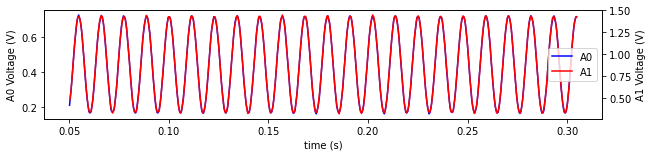

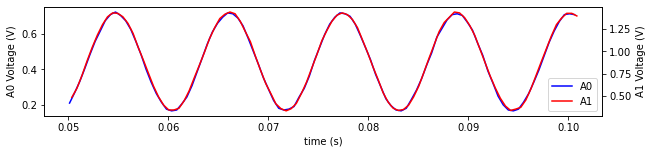

In [8]:
signals, times = read_and_discard(number_to_read=2000)

plot_opamp_signals(signals[:, :500], times[:, :500]) 
plot_opamp_signals(signals[:, :100], times[:, :100])

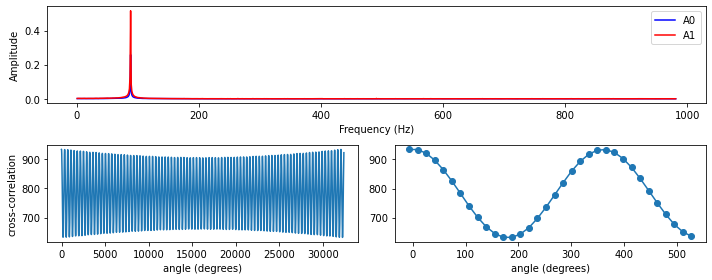

Ch0: Fundamental frequency at 88.36797698461257, with amplitude 0.25846636295318604.
Ch1: Fundamental frequency at 88.36797698461257, with amplitude 0.5158848762512207.
Nyquist frequency as last point in FFT = 980.8845445291996
Phase-shift = 5.843475341796875 +/- 3.453047094767209
[88.36797698 88.36797698]
[0.25846636 0.5158849 ]
(5.843475341796875, 3.453047094767209)


In [9]:
f, A, phase = FFT(signals, times)
print(f)
print(A)
print(phase)

In [15]:
print("Voltage Gain")
print(0.5158848762512207/0.25846636295318604)

Voltage Gain
1.9959458954612939


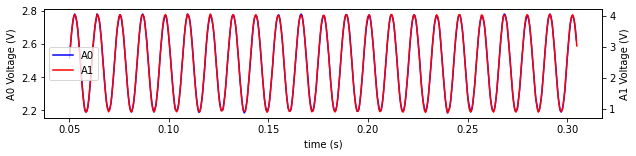

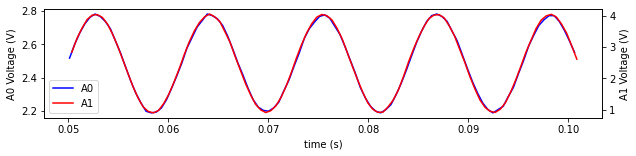

In [24]:
signals, times = read_and_discard(number_to_read=2000)

plot_opamp_signals(signals[:, :500], times[:, :500]) 
plot_opamp_signals(signals[:, :100], times[:, :100])

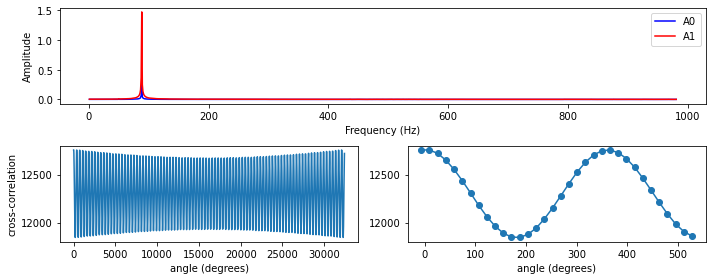

Ch0: Fundamental frequency at 88.36797698461257, with amplitude 0.2732996344566345.
Ch1: Fundamental frequency at 88.36797698461257, with amplitude 1.4730336666107178.
Nyquist frequency as last point in FFT = 980.8845445291996
Phase-shift = 5.843475341796875 +/- 3.453047094767209
[88.36797698 88.36797698]
[0.27329963 1.4730337 ]
(5.843475341796875, 3.453047094767209)


In [25]:
f, A, phase = FFT(signals, times)
print(f)
print(A)
print(phase)

In [26]:
print("Voltage Gain")
print(1.4730336666107178/0.2732996344566345)

Voltage Gain
5.389812063010459
